In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [20]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json

class SemEvalDataset(Dataset):
    def __init__(self, file_path):
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
        self.data = []
        with open(file_path, 'r') as file:
            for line in tqdm(file, desc=f"Reading {file_path}"):
                line_data = json.loads(line)
                text = line_data['text']
                inputs = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=128)
                self.data.append({
                    'input_ids': inputs['input_ids'].squeeze(),
                    'attention_mask': inputs['attention_mask'].squeeze(),
                    'labels': line_data['label']
                })
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = SemEvalDataset('../Dataset/subtaskB_train.jsonl')
test_dataset = SemEvalDataset('../Dataset/subtaskB_dev.jsonl')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Reading ../Datasets/subtaskB_train.jsonl: 71027it [01:19, 895.07it/s] 
Reading ../Datasets/subtaskB_dev.jsonl: 3000it [00:02, 1297.54it/s]


In [21]:
from torch.utils.data import RandomSampler

trainset_size = len(train_dataset)
sample_1_percentage = 1
generator = torch.Generator().manual_seed(42)
sample_1_sampler = RandomSampler(train_dataset, replacement=True, num_samples=int(trainset_size * sample_1_percentage / 100), generator=generator)
sample_1_loader = DataLoader(train_dataset, batch_size=32, sampler=sample_1_sampler)
sample_2_percentage = 5
generator = torch.Generator().manual_seed(42)
sample_2_sampler = RandomSampler(train_dataset, replacement=True, num_samples=int(trainset_size * sample_2_percentage / 100), generator=generator)
sample_2_loader = DataLoader(train_dataset, batch_size=32, sampler=sample_2_sampler)
sample_3_percentage = 10
generator = torch.Generator().manual_seed(42)
sample_3_sampler = RandomSampler(train_dataset, replacement=True, num_samples=int(trainset_size * sample_3_percentage / 100), generator=generator)
sample_3_loader = DataLoader(train_dataset, batch_size=32, sampler=sample_3_sampler)
sample_4_percentage = 50
generator = torch.Generator().manual_seed(42)
sample_4_sampler = RandomSampler(train_dataset, replacement=True, num_samples=int(trainset_size * sample_4_percentage / 100), generator=generator)
sample_4_loader = DataLoader(train_dataset, batch_size=32, sampler=sample_4_sampler)

# BERT Classifier

In [10]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.pooler_output)

In [11]:
import matplotlib.pyplot as plt

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            pbar.set_description(f"Accuracy: {correct / total}")
    return correct / total

def train(model, loader, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    accuracys = []
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        accuracy = evaluate(model, test_loader)
        accuracys.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {accuracy}")
    return accuracys

def plot(accuracys, name):
    plt.plot(accuracys)
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(f'../Plots/{name}.png')
    save_results(accuracys, name)
    plt.show()

def save_results(accuracys, name):
    with open(f'../Results/{name}.txt', 'w') as file:
        for accuracy in accuracys:
            file.write(f"{accuracy}\n")

## No Adapter

### 1%

Accuracy: 0.15033333333333335: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s] 


Epoch 1/30 - Accuracy: 0.15033333333333335


Accuracy: 0.188: 100%|██████████| 47/47 [00:07<00:00,  6.22it/s]              


Epoch 2/30 - Accuracy: 0.188


Accuracy: 0.192: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s]               


Epoch 3/30 - Accuracy: 0.192


Accuracy: 0.22166666666666668: 100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch 4/30 - Accuracy: 0.22166666666666668


Accuracy: 0.2836666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.45it/s] 


Epoch 5/30 - Accuracy: 0.2836666666666667


Accuracy: 0.27666666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]


Epoch 6/30 - Accuracy: 0.27666666666666667


Accuracy: 0.42133333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


Epoch 7/30 - Accuracy: 0.42133333333333334


Accuracy: 0.39166666666666666: 100%|██████████| 47/47 [00:10<00:00,  4.28it/s]


Epoch 8/30 - Accuracy: 0.39166666666666666


Accuracy: 0.37933333333333336: 100%|██████████| 47/47 [00:11<00:00,  4.27it/s]


Epoch 9/30 - Accuracy: 0.37933333333333336


Accuracy: 0.4196666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.10it/s] 


Epoch 10/30 - Accuracy: 0.4196666666666667


Accuracy: 0.43633333333333335: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


Epoch 11/30 - Accuracy: 0.43633333333333335


Accuracy: 0.45: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s]               


Epoch 12/30 - Accuracy: 0.45


Accuracy: 0.375: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]              


Epoch 13/30 - Accuracy: 0.375


Accuracy: 0.38533333333333336: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch 14/30 - Accuracy: 0.38533333333333336


Accuracy: 0.3943333333333333: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s] 


Epoch 15/30 - Accuracy: 0.3943333333333333


Accuracy: 0.41933333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]


Epoch 16/30 - Accuracy: 0.41933333333333334


Accuracy: 0.363: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]               


Epoch 17/30 - Accuracy: 0.363


Accuracy: 0.39566666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


Epoch 18/30 - Accuracy: 0.39566666666666667


Accuracy: 0.41233333333333333: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


Epoch 19/30 - Accuracy: 0.41233333333333333


Accuracy: 0.44333333333333336: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


Epoch 20/30 - Accuracy: 0.44333333333333336


Accuracy: 0.44233333333333336: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


Epoch 21/30 - Accuracy: 0.44233333333333336


Accuracy: 0.385: 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]              


Epoch 22/30 - Accuracy: 0.385


Accuracy: 0.36733333333333335: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


Epoch 23/30 - Accuracy: 0.36733333333333335


Accuracy: 0.436: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]              


Epoch 24/30 - Accuracy: 0.436


Accuracy: 0.416: 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]              


Epoch 25/30 - Accuracy: 0.416


Accuracy: 0.42933333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


Epoch 26/30 - Accuracy: 0.42933333333333334


Accuracy: 0.476: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]              


Epoch 27/30 - Accuracy: 0.476


Accuracy: 0.4226666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s] 


Epoch 28/30 - Accuracy: 0.4226666666666667


Accuracy: 0.463: 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]              


Epoch 29/30 - Accuracy: 0.463


Accuracy: 0.47933333333333333: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]

Epoch 30/30 - Accuracy: 0.47933333333333333


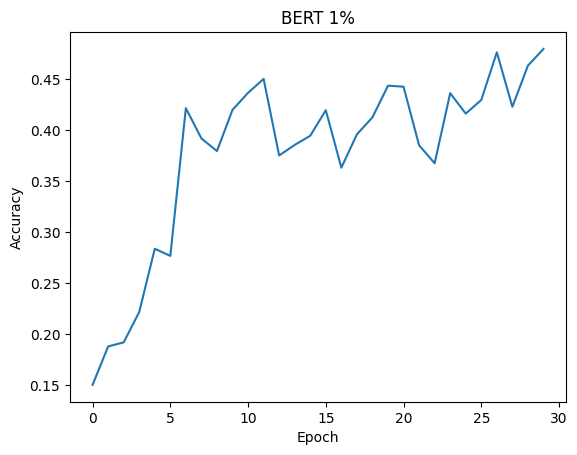

In [6]:
model = BERTClassifier(6).to(device)
accs_1 = train(model, sample_1_loader, epochs=30)
plot(accs_1, 'BERT 1%')

### 5%

Accuracy: 0.284: 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]              


Epoch 1/6 - Accuracy: 0.284


Accuracy: 0.43033333333333335: 100%|██████████| 47/47 [00:10<00:00,  4.34it/s]


Epoch 2/6 - Accuracy: 0.43033333333333335


Accuracy: 0.43866666666666665: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 3/6 - Accuracy: 0.43866666666666665


Accuracy: 0.49666666666666665: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 4/6 - Accuracy: 0.49666666666666665


Accuracy: 0.443: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]              


Epoch 5/6 - Accuracy: 0.443


Accuracy: 0.5016666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.35it/s] 

Epoch 6/6 - Accuracy: 0.5016666666666667


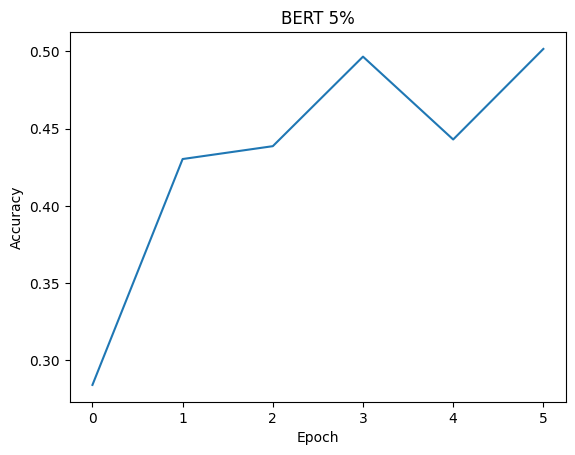

In [7]:
model = BERTClassifier(6).to(device)
accs_2 = train(model, sample_2_loader, epochs=6)
plot(accs_2, 'BERT 5%')

### 10%

Accuracy: 0.416: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]              


Epoch 1/3 - Accuracy: 0.416


Accuracy: 0.43266666666666664: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


Epoch 2/3 - Accuracy: 0.43266666666666664


Accuracy: 0.4806666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.23it/s] 

Epoch 3/3 - Accuracy: 0.4806666666666667


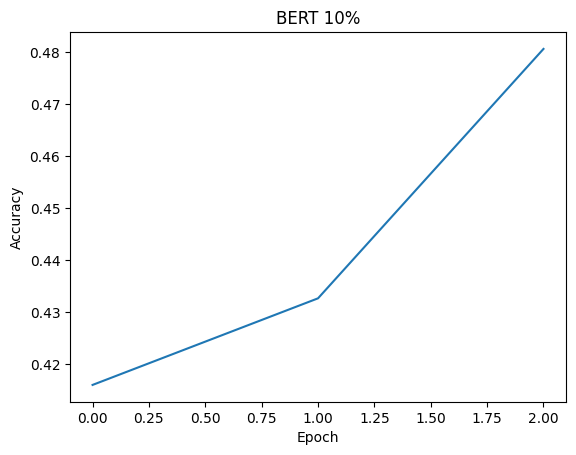

In [8]:
model = BERTClassifier(6).to(device)
accs_3 = train(model, sample_3_loader, epochs=3)
plot(accs_3, 'BERT 10%')

### 50%

Accuracy: 0.527: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]              


Epoch 1/3 - Accuracy: 0.527


Accuracy: 0.5053333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.29it/s] 


Epoch 2/3 - Accuracy: 0.5053333333333333


Accuracy: 0.531: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]              

Epoch 3/3 - Accuracy: 0.531


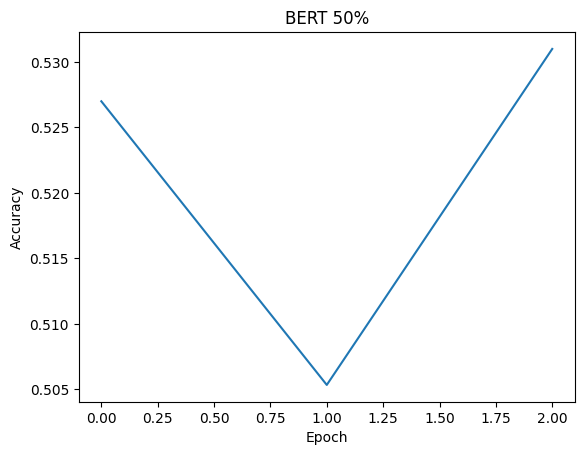

In [9]:
model = BERTClassifier(6).to(device)
accs_4 = train(model, sample_4_loader, epochs=3)
plot(accs_4, 'BERT 50%')

## Adapter

In [10]:
import adapters
from adapters import AdapterTrainer
from transformers import AutoModelForSequenceClassification, TrainingArguments
from torch.utils.data import Subset

def get_model():
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6).to(device)
    adapters.init(model)
    model.add_adapter('sem_eval', config='seq_bn')
    model.bert.train_adapter('sem_eval')
    return model

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": (preds == p.label_ids).mean()}

def train_adapter(model, select, epochs=3):
    trainset_size = len(train_dataset) * select / 100
    generator = torch.Generator().manual_seed(42)
    torch.manual_seed(42)
    indices = torch.randperm(len(train_dataset), generator=generator).tolist()
    indices = indices[:int(trainset_size)]
    subset = Subset(train_dataset, indices)
    training_args = TrainingArguments(
        output_dir='../Results',
        num_train_epochs=epochs,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        full_determinism=False,
        learning_rate=5e-5,
        evaluation_strategy="epoch",
        seed=42,
    )
    trainer = AdapterTrainer(
        model=model,
        args=training_args,
        train_dataset=subset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer.evaluate()

### 1%

In [11]:
model = get_model()
accs_1 = train_adapter(model, 1, epochs=30)
accs_1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.8142379522323608, 'eval_accuracy': 0.14166666666666666, 'eval_runtime': 10.7354, 'eval_samples_per_second': 279.449, 'eval_steps_per_second': 4.378, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.8052364587783813, 'eval_accuracy': 0.14, 'eval_runtime': 11.33, 'eval_samples_per_second': 264.784, 'eval_steps_per_second': 4.148, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.805070161819458, 'eval_accuracy': 0.13533333333333333, 'eval_runtime': 11.7977, 'eval_samples_per_second': 254.286, 'eval_steps_per_second': 3.984, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.8041685819625854, 'eval_accuracy': 0.138, 'eval_runtime': 11.4964, 'eval_samples_per_second': 260.951, 'eval_steps_per_second': 4.088, 'epoch': 4.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.802148461341858, 'eval_accuracy': 0.14666666666666667, 'eval_runtime': 11.8505, 'eval_samples_per_second': 253.154, 'eval_steps_per_second': 3.966, 'epoch': 5.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.8010942935943604, 'eval_accuracy': 0.147, 'eval_runtime': 11.3069, 'eval_samples_per_second': 265.324, 'eval_steps_per_second': 4.157, 'epoch': 6.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7991313934326172, 'eval_accuracy': 0.15266666666666667, 'eval_runtime': 11.6618, 'eval_samples_per_second': 257.25, 'eval_steps_per_second': 4.03, 'epoch': 7.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7973606586456299, 'eval_accuracy': 0.15166666666666667, 'eval_runtime': 11.1705, 'eval_samples_per_second': 268.564, 'eval_steps_per_second': 4.208, 'epoch': 8.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7966736555099487, 'eval_accuracy': 0.15366666666666667, 'eval_runtime': 11.6435, 'eval_samples_per_second': 257.655, 'eval_steps_per_second': 4.037, 'epoch': 9.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.79584801197052, 'eval_accuracy': 0.163, 'eval_runtime': 11.6875, 'eval_samples_per_second': 256.685, 'eval_steps_per_second': 4.021, 'epoch': 10.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7945632934570312, 'eval_accuracy': 0.174, 'eval_runtime': 11.551, 'eval_samples_per_second': 259.718, 'eval_steps_per_second': 4.069, 'epoch': 11.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.791841745376587, 'eval_accuracy': 0.17566666666666667, 'eval_runtime': 11.955, 'eval_samples_per_second': 250.941, 'eval_steps_per_second': 3.931, 'epoch': 12.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7912366390228271, 'eval_accuracy': 0.183, 'eval_runtime': 11.8192, 'eval_samples_per_second': 253.825, 'eval_steps_per_second': 3.977, 'epoch': 13.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7871774435043335, 'eval_accuracy': 0.18866666666666668, 'eval_runtime': 11.3161, 'eval_samples_per_second': 265.11, 'eval_steps_per_second': 4.153, 'epoch': 14.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7851927280426025, 'eval_accuracy': 0.193, 'eval_runtime': 11.3261, 'eval_samples_per_second': 264.875, 'eval_steps_per_second': 4.15, 'epoch': 15.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7841767072677612, 'eval_accuracy': 0.20033333333333334, 'eval_runtime': 11.399, 'eval_samples_per_second': 263.181, 'eval_steps_per_second': 4.123, 'epoch': 16.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7851237058639526, 'eval_accuracy': 0.19566666666666666, 'eval_runtime': 11.3646, 'eval_samples_per_second': 263.977, 'eval_steps_per_second': 4.136, 'epoch': 17.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7783225774765015, 'eval_accuracy': 0.20266666666666666, 'eval_runtime': 11.343, 'eval_samples_per_second': 264.48, 'eval_steps_per_second': 4.144, 'epoch': 18.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.777652382850647, 'eval_accuracy': 0.204, 'eval_runtime': 11.4033, 'eval_samples_per_second': 263.081, 'eval_steps_per_second': 4.122, 'epoch': 19.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7759315967559814, 'eval_accuracy': 0.20433333333333334, 'eval_runtime': 11.7097, 'eval_samples_per_second': 256.197, 'eval_steps_per_second': 4.014, 'epoch': 20.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7754504680633545, 'eval_accuracy': 0.20666666666666667, 'eval_runtime': 11.7482, 'eval_samples_per_second': 255.358, 'eval_steps_per_second': 4.001, 'epoch': 21.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.775229811668396, 'eval_accuracy': 0.207, 'eval_runtime': 11.5574, 'eval_samples_per_second': 259.575, 'eval_steps_per_second': 4.067, 'epoch': 22.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7763320207595825, 'eval_accuracy': 0.20666666666666667, 'eval_runtime': 12.0855, 'eval_samples_per_second': 248.232, 'eval_steps_per_second': 3.889, 'epoch': 23.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7753205299377441, 'eval_accuracy': 0.207, 'eval_runtime': 11.3267, 'eval_samples_per_second': 264.86, 'eval_steps_per_second': 4.149, 'epoch': 24.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.776540994644165, 'eval_accuracy': 0.20733333333333334, 'eval_runtime': 11.8549, 'eval_samples_per_second': 253.06, 'eval_steps_per_second': 3.965, 'epoch': 25.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.773056983947754, 'eval_accuracy': 0.20833333333333334, 'eval_runtime': 11.5245, 'eval_samples_per_second': 260.315, 'eval_steps_per_second': 4.078, 'epoch': 26.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7701709270477295, 'eval_accuracy': 0.21266666666666667, 'eval_runtime': 12.4152, 'eval_samples_per_second': 241.64, 'eval_steps_per_second': 3.786, 'epoch': 27.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7699869871139526, 'eval_accuracy': 0.212, 'eval_runtime': 11.3615, 'eval_samples_per_second': 264.049, 'eval_steps_per_second': 4.137, 'epoch': 28.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7695013284683228, 'eval_accuracy': 0.21266666666666667, 'eval_runtime': 11.3411, 'eval_samples_per_second': 264.524, 'eval_steps_per_second': 4.144, 'epoch': 29.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7690393924713135, 'eval_accuracy': 0.213, 'eval_runtime': 11.3732, 'eval_samples_per_second': 263.779, 'eval_steps_per_second': 4.133, 'epoch': 30.0}
{'train_runtime': 501.5703, 'train_samples_per_second': 42.467, 'train_steps_per_second': 0.718, 'train_loss': 1.7384819878472222, 'epoch': 30.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7690393924713135,
 'eval_accuracy': 0.213,
 'eval_runtime': 11.3728,
 'eval_samples_per_second': 263.787,
 'eval_steps_per_second': 4.133,
 'epoch': 30.0}

### 5%

In [12]:
model = get_model()
accs_2 = train_adapter(model, 5, epochs=6)
accs_2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7949632406234741, 'eval_accuracy': 0.17066666666666666, 'eval_runtime': 9.9726, 'eval_samples_per_second': 300.824, 'eval_steps_per_second': 4.713, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7914077043533325, 'eval_accuracy': 0.17533333333333334, 'eval_runtime': 11.5154, 'eval_samples_per_second': 260.521, 'eval_steps_per_second': 4.081, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7833127975463867, 'eval_accuracy': 0.19266666666666668, 'eval_runtime': 11.6798, 'eval_samples_per_second': 256.853, 'eval_steps_per_second': 4.024, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7716487646102905, 'eval_accuracy': 0.22533333333333333, 'eval_runtime': 12.0765, 'eval_samples_per_second': 248.417, 'eval_steps_per_second': 3.892, 'epoch': 4.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7570055723190308, 'eval_accuracy': 0.232, 'eval_runtime': 11.2354, 'eval_samples_per_second': 267.014, 'eval_steps_per_second': 4.183, 'epoch': 5.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.751961588859558, 'eval_accuracy': 0.232, 'eval_runtime': 11.7342, 'eval_samples_per_second': 255.662, 'eval_steps_per_second': 4.005, 'epoch': 6.0}
{'train_runtime': 217.6226, 'train_samples_per_second': 97.903, 'train_steps_per_second': 1.544, 'train_loss': 1.778338841029576, 'epoch': 6.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.751961588859558,
 'eval_accuracy': 0.232,
 'eval_runtime': 11.7083,
 'eval_samples_per_second': 256.229,
 'eval_steps_per_second': 4.014,
 'epoch': 6.0}

### 10%

In [13]:
model = get_model()
accs_3 = train_adapter(model, 10, epochs=3)
accs_3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7906644344329834, 'eval_accuracy': 0.18966666666666668, 'eval_runtime': 11.0012, 'eval_samples_per_second': 272.698, 'eval_steps_per_second': 4.272, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.7826337814331055, 'eval_accuracy': 0.201, 'eval_runtime': 11.5478, 'eval_samples_per_second': 259.79, 'eval_steps_per_second': 4.07, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.777984380722046, 'eval_accuracy': 0.20566666666666666, 'eval_runtime': 12.0371, 'eval_samples_per_second': 249.23, 'eval_steps_per_second': 3.905, 'epoch': 3.0}
{'train_runtime': 184.4011, 'train_samples_per_second': 115.542, 'train_steps_per_second': 1.806, 'train_loss': 1.79162744287256, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.777984380722046,
 'eval_accuracy': 0.20566666666666666,
 'eval_runtime': 11.4171,
 'eval_samples_per_second': 262.763,
 'eval_steps_per_second': 4.117,
 'epoch': 3.0}

### 50%

In [14]:
model = get_model()
accs_4 = train_adapter(model, 50, epochs=3)
accs_4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1665 [00:00<?, ?it/s]

{'loss': 1.6666, 'learning_rate': 3.498498498498499e-05, 'epoch': 0.9}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.6902189254760742, 'eval_accuracy': 0.25333333333333335, 'eval_runtime': 11.5975, 'eval_samples_per_second': 258.676, 'eval_steps_per_second': 4.053, 'epoch': 1.0}
{'loss': 1.3192, 'learning_rate': 1.996996996996997e-05, 'epoch': 1.8}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.538845419883728, 'eval_accuracy': 0.33866666666666667, 'eval_runtime': 11.858, 'eval_samples_per_second': 252.993, 'eval_steps_per_second': 3.964, 'epoch': 2.0}
{'loss': 1.203, 'learning_rate': 4.954954954954955e-06, 'epoch': 2.7}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.524609088897705, 'eval_accuracy': 0.358, 'eval_runtime': 11.4795, 'eval_samples_per_second': 261.336, 'eval_steps_per_second': 4.094, 'epoch': 3.0}
{'train_runtime': 805.4831, 'train_samples_per_second': 132.267, 'train_steps_per_second': 2.067, 'train_loss': 1.3744464771167653, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.524609088897705,
 'eval_accuracy': 0.358,
 'eval_runtime': 11.9059,
 'eval_samples_per_second': 251.977,
 'eval_steps_per_second': 3.948,
 'epoch': 3.0}

# GAN-BERT

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(768, 256)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes + 1)
    
    def forward(self, x):
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        y = self.dropout2(x)
        y = self.fc2(y)
        return y, x

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
    
    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids, attention_mask=attention_mask).pooler_output

class GeneratorG1(nn.Module):
    def __init__(self):
        super(GeneratorG1, self).__init__()
        self.fc1 = nn.Linear(100, 768)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(768, 768)

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class GeneratorG2(nn.Module):
    def __init__(self):
        super(GeneratorG2, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids, attention_mask=attention_mask).pooler_output

In [7]:
def evaluate_discriminator(discriminator, bert, loader):
    discriminator.eval()
    bert.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs, _ = discriminator(bert(input_ids, attention_mask=attention_mask))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            pbar.set_description(f"Accuracy: {correct / total}")
    return correct / total

def train_gan_g1(generator, discriminator, bert, loader, epochs=3, num_classes=6):
    optimizer_g = torch.optim.AdamW(generator.parameters(), lr=1e-4)
    optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr=2.5e-4)
    optimizer_b = torch.optim.AdamW(bert.parameters(), lr=5e-5)
    generator.train()
    accuracys = []
    torch.manual_seed(42)
    for epoch in range(epochs):
        discriminator.train()
        bert.train()
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer_d.zero_grad()
            optimizer_b.zero_grad()
            fake_size = 2 * labels.size(0) // num_classes
            Z = torch.randn(fake_size, 100).to(device)
            generated = generator(Z)
            fake_logits, _ = discriminator(generated)
            fake_probs = F.softmax(fake_logits, dim=-1)
            bert_outputs = bert(input_ids, attention_mask=attention_mask)
            real_logits, real_features = discriminator(bert_outputs)
            real_features = real_features.detach()
            real_probs = F.softmax(real_logits, dim=-1)
            real_logprobs = F.log_softmax(real_logits[:, :-1], dim=-1)
            label2one_hot = F.one_hot(labels, num_classes).to(device)
            loss_supervised = -torch.sum(label2one_hot * real_logprobs, dim=-1).mean()
            loss_unsupervised = -torch.mean(torch.log(1 - real_probs[:, -1] + 1e-8)) - torch.mean(torch.log(fake_probs[:, -1] + 1e-8))
            loss_d = loss_supervised + loss_unsupervised
            loss_d.backward()
            optimizer_d.step()
            optimizer_b.step()
            optimizer_g.zero_grad()
            generated = generator(Z)
            fake_logits, fake_features = discriminator(generated)
            fake_probs = F.softmax(fake_logits, dim=-1)
            loss_g = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + 1e-8)) + (fake_features.mean(0) - real_features.mean(0)).pow(2).mean()
            loss_g.backward()
            optimizer_g.step()
            pbar.set_description(f"Loss G: {loss_g.item():.4f} - Loss D: {loss_d.item():.4f}")
        accuracy = evaluate_discriminator(discriminator, bert, test_loader)
        accuracys.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {accuracy}")
    return accuracys

## Generator G1

### 1%

Accuracy: 0.18366666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.29it/s] 


Epoch 1/30 - Accuracy: 0.18366666666666667


Accuracy: 0.21366666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s] 


Epoch 2/30 - Accuracy: 0.21366666666666667


Accuracy: 0.20133333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


Epoch 3/30 - Accuracy: 0.20133333333333334


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


Epoch 4/30 - Accuracy: 0.16666666666666666


Accuracy: 0.26966666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.27it/s]


Epoch 5/30 - Accuracy: 0.26966666666666667


Accuracy: 0.22433333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 6/30 - Accuracy: 0.22433333333333333


Accuracy: 0.16066666666666668: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


Epoch 7/30 - Accuracy: 0.16066666666666668


Accuracy: 0.2623333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.46it/s] 


Epoch 8/30 - Accuracy: 0.2623333333333333


Accuracy: 0.27066666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.44it/s] 


Epoch 9/30 - Accuracy: 0.27066666666666667


Accuracy: 0.249: 100%|██████████| 47/47 [00:10<00:00,  4.35it/s]              


Epoch 10/30 - Accuracy: 0.249


Accuracy: 0.20933333333333334: 100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch 11/30 - Accuracy: 0.20933333333333334


Accuracy: 0.2: 100%|██████████| 47/47 [00:11<00:00,  4.23it/s]                


Epoch 12/30 - Accuracy: 0.2


Accuracy: 0.21233333333333335: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


Epoch 13/30 - Accuracy: 0.21233333333333335


Accuracy: 0.17733333333333334: 100%|██████████| 47/47 [00:10<00:00,  4.28it/s]


Epoch 14/30 - Accuracy: 0.17733333333333334


Accuracy: 0.21233333333333335: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


Epoch 15/30 - Accuracy: 0.21233333333333335


Accuracy: 0.28933333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


Epoch 16/30 - Accuracy: 0.28933333333333333


Accuracy: 0.26266666666666666: 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]


Epoch 17/30 - Accuracy: 0.26266666666666666


Accuracy: 0.25266666666666665: 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


Epoch 18/30 - Accuracy: 0.25266666666666665


Accuracy: 0.30533333333333335: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch 19/30 - Accuracy: 0.30533333333333335


Accuracy: 0.32033333333333336: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


Epoch 20/30 - Accuracy: 0.32033333333333336


Accuracy: 0.30666666666666664: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 21/30 - Accuracy: 0.30666666666666664


Accuracy: 0.3436666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s] 


Epoch 22/30 - Accuracy: 0.3436666666666667


Accuracy: 0.32133333333333336: 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


Epoch 23/30 - Accuracy: 0.32133333333333336


Accuracy: 0.2876666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.39it/s] 


Epoch 24/30 - Accuracy: 0.2876666666666667


Accuracy: 0.3983333333333333: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s] 


Epoch 25/30 - Accuracy: 0.3983333333333333


Accuracy: 0.398: 100%|██████████| 47/47 [00:10<00:00,  4.30it/s]              


Epoch 26/30 - Accuracy: 0.398


Accuracy: 0.40166666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


Epoch 27/30 - Accuracy: 0.40166666666666667


Accuracy: 0.418: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]              


Epoch 28/30 - Accuracy: 0.418


Accuracy: 0.32866666666666666: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 29/30 - Accuracy: 0.32866666666666666


Accuracy: 0.385: 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]              

Epoch 30/30 - Accuracy: 0.385


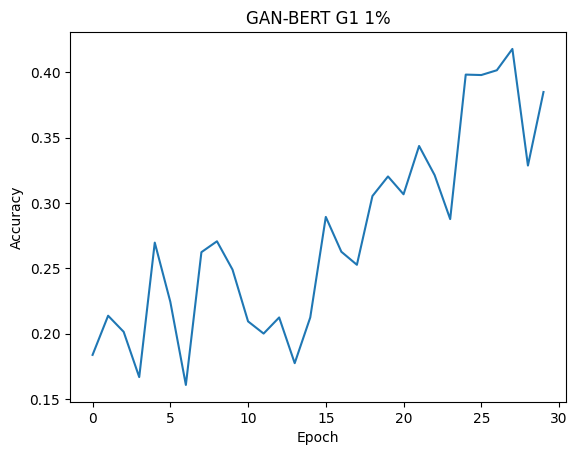

In [17]:
bert = BERT().to(device)
generator_g1 = GeneratorG1().to(device)
discriminator = Discriminator(6).to(device)
accs_g1_1 = train_gan_g1(generator_g1, discriminator, bert, sample_1_loader, epochs=30)
plot(accs_g1_1, 'GAN-BERT G1 1%')

### 5%

Accuracy: 0.2783333333333333: 100%|██████████| 47/47 [00:09<00:00,  4.81it/s] 


Epoch 1/6 - Accuracy: 0.2783333333333333


Accuracy: 0.19833333333333333: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch 2/6 - Accuracy: 0.19833333333333333


Accuracy: 0.38166666666666665: 100%|██████████| 47/47 [00:10<00:00,  4.44it/s]


Epoch 3/6 - Accuracy: 0.38166666666666665


Accuracy: 0.448: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s]              


Epoch 4/6 - Accuracy: 0.448


Accuracy: 0.4876666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s] 


Epoch 5/6 - Accuracy: 0.4876666666666667


Accuracy: 0.3983333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.42it/s] 

Epoch 6/6 - Accuracy: 0.3983333333333333


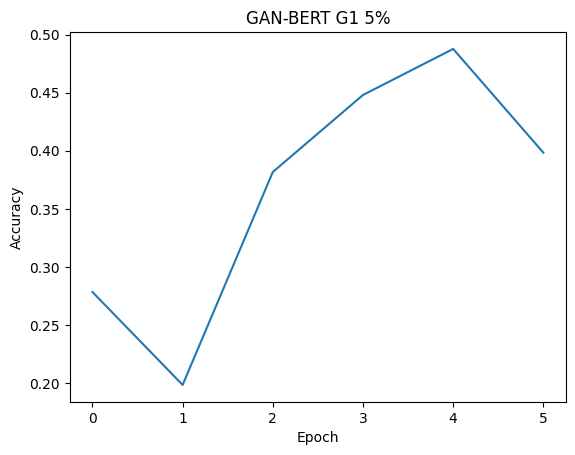

In [18]:
bert = BERT().to(device)
generator_g1 = GeneratorG1().to(device)
discriminator = Discriminator(6).to(device)
accs_g1_2 = train_gan_g1(generator_g1, discriminator, bert, sample_2_loader, epochs=6)
plot(accs_g1_2, 'GAN-BERT G1 5%')

### 10%

Accuracy: 0.31833333333333336: 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


Epoch 1/3 - Accuracy: 0.31833333333333336


Accuracy: 0.49: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]               


Epoch 2/3 - Accuracy: 0.49


Accuracy: 0.477: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]              

Epoch 3/3 - Accuracy: 0.477


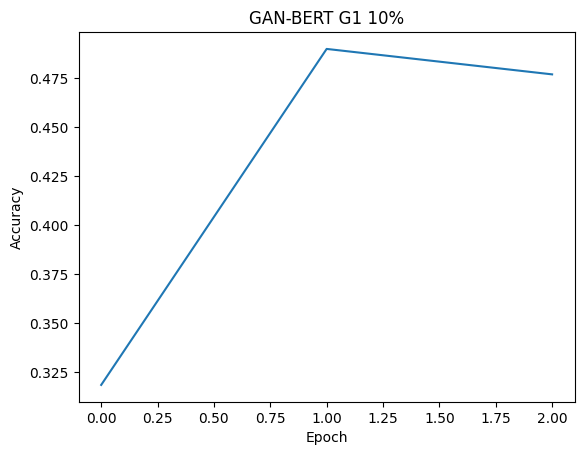

In [19]:
bert = BERT().to(device)
generator_g1 = GeneratorG1().to(device)
discriminator = Discriminator(6).to(device)
accs_g1_3 = train_gan_g1(generator_g1, discriminator, bert, sample_3_loader, epochs=3)
plot(accs_g1_3, 'GAN-BERT G1 10%')

### 50%

Accuracy: 0.4856666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s] 


Epoch 1/3 - Accuracy: 0.4856666666666667


Accuracy: 0.501: 100%|██████████| 47/47 [00:10<00:00,  4.32it/s]              


Epoch 2/3 - Accuracy: 0.501


Accuracy: 0.503: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]              

Epoch 3/3 - Accuracy: 0.503


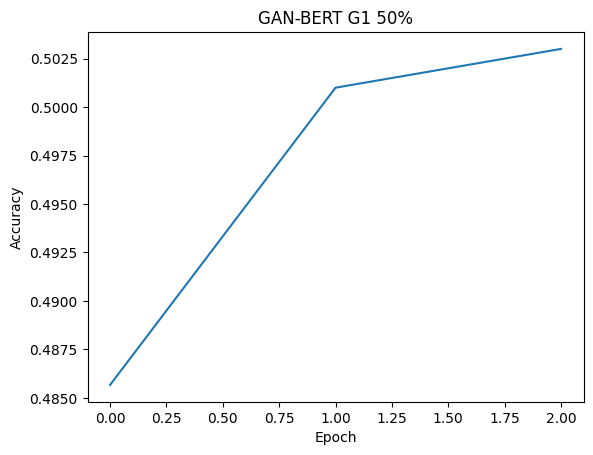

In [20]:
bert = BERT().to(device)
generator_g1 = GeneratorG1().to(device)
discriminator = Discriminator(6).to(device)
accs_g1_4 = train_gan_g1(generator_g1, discriminator, bert, sample_4_loader, epochs=3)
plot(accs_g1_4, 'GAN-BERT G1 50%')

## Generator G2

In [21]:
import bisect

def get_tokens_distribution(loader):
    tokens = dict()
    for batch in tqdm(loader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        for i in range(input_ids.size(0)):
            tokens_ids = input_ids[i][attention_mask[i] == 1]
            for token_id in tokens_ids:
                if token_id.item() in tokens:
                    tokens[token_id.item()] += 1
                else:
                    tokens[token_id.item()] = 1
    return tokens

def init_tokens_distribution(loader):
    tokens = get_tokens_distribution(loader)
    token_probs = dict()
    total = sum(tokens.values())
    for token, count in tokens.items():
        token_probs[token] = count / total
    CDF = []
    tokens = list(token_probs.keys())
    cumulative = 0
    for token in tokens:
        prob = token_probs[token]
        cumulative += prob
        CDF.append(cumulative)
    return CDF, tokens

def sample_tokens(CDF, tokens, n):
    out = []
    rands = torch.rand(n)
    for i in range(n):
        r = rands[i].item()
        idx = bisect.bisect_left(CDF, r)
        out.append(tokens[idx])
    return out

CDF, tokens = init_tokens_distribution(sample_4_loader)

100%|██████████| 555/555 [00:05<00:00, 102.25it/s]


In [22]:
def train_gan_g2(generator, discriminator, bert, loader, epochs=3, num_classes=6):
    optimizer_g = torch.optim.AdamW(generator.parameters(), lr=5e-5)
    optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr=2.5e-4)
    optimizer_b = torch.optim.AdamW(bert.parameters(), lr=5e-5)
    generator.train()
    accuracys = []
    torch.manual_seed(42)
    for epoch in range(epochs):
        discriminator.train()
        bert.train()
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer_d.zero_grad()
            optimizer_b.zero_grad()
            fake_size = 2 * labels.size(0) // num_classes
            Z = torch.tensor(sample_tokens(CDF, tokens, fake_size)).reshape(-1, 1).to(device)
            Z_attention_mask = torch.ones_like(Z)
            generated = generator(Z, attention_mask=Z_attention_mask)
            fake_logits, _ = discriminator(generated)
            fake_probs = F.softmax(fake_logits, dim=-1)
            bert_outputs = bert(input_ids, attention_mask=attention_mask)
            real_logits, real_features = discriminator(bert_outputs)
            real_features = real_features.detach()
            real_probs = F.softmax(real_logits, dim=-1)
            real_logprobs = F.log_softmax(real_logits[:, :-1], dim=-1)
            label2one_hot = F.one_hot(labels, num_classes).to(device)
            loss_supervised = -torch.sum(label2one_hot * real_logprobs, dim=-1).mean()
            loss_unsupervised = -torch.mean(torch.log(1 - real_probs[:, -1] + 1e-8)) - torch.mean(torch.log(fake_probs[:, -1] + 1e-8))
            loss_d = loss_supervised + loss_unsupervised
            loss_d.backward(retain_graph=True)
            optimizer_d.step()
            optimizer_b.step()
            optimizer_g.zero_grad()
            fake_logits, fake_features = discriminator(generated)
            fake_probs = F.softmax(fake_logits, dim=-1)
            loss_g = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + 1e-8)) + (fake_features.mean(0) - real_features.mean(0)).pow(2).mean()
            loss_g.backward()
            optimizer_g.step()
            pbar.set_description(f"Loss G: {loss_g.item():.4f} - Loss D: {loss_d.item():.4f}")
        accuracy = evaluate_discriminator(discriminator, bert, test_loader)
        accuracys.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {accuracy}")
    return accuracys

### 1%

Accuracy: 0.13: 100%|██████████| 47/47 [00:08<00:00,  5.51it/s]               


Epoch 1/30 - Accuracy: 0.13


Accuracy: 0.17133333333333334: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 2/30 - Accuracy: 0.17133333333333334


Accuracy: 0.0: 100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Epoch 3/30 - Accuracy: 0.0


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.28it/s]


Epoch 4/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch 5/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 6/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


Epoch 7/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 8/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.26it/s]


Epoch 9/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch 10/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Epoch 11/30 - Accuracy: 0.16666666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Epoch 12/30 - Accuracy: 0.16666666666666666


Accuracy: 0.18666666666666668: 100%|██████████| 47/47 [00:08<00:00,  5.46it/s]


Epoch 13/30 - Accuracy: 0.18666666666666668


Accuracy: 0.0: 100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Epoch 14/30 - Accuracy: 0.0


Accuracy: 0.178: 100%|██████████| 47/47 [00:08<00:00,  5.45it/s]              


Epoch 15/30 - Accuracy: 0.178


Accuracy: 0.26066666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Epoch 16/30 - Accuracy: 0.26066666666666666


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 17/30 - Accuracy: 0.16666666666666666


Accuracy: 0.005333333333333333: 100%|██████████| 47/47 [00:08<00:00,  5.44it/s] 


Epoch 18/30 - Accuracy: 0.005333333333333333


Accuracy: 0.022333333333333334: 100%|██████████| 47/47 [00:08<00:00,  5.38it/s] 


Epoch 19/30 - Accuracy: 0.022333333333333334


Accuracy: 0.19566666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Epoch 20/30 - Accuracy: 0.19566666666666666


Accuracy: 0.13066666666666665: 100%|██████████| 47/47 [00:08<00:00,  5.47it/s] 


Epoch 21/30 - Accuracy: 0.13066666666666665


Accuracy: 0.174: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s]               


Epoch 22/30 - Accuracy: 0.174


Accuracy: 0.11133333333333334: 100%|██████████| 47/47 [00:08<00:00,  5.40it/s] 


Epoch 23/30 - Accuracy: 0.11133333333333334


Accuracy: 0.15133333333333332: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s] 


Epoch 24/30 - Accuracy: 0.15133333333333332


Accuracy: 0.16266666666666665: 100%|██████████| 47/47 [00:08<00:00,  5.44it/s] 


Epoch 25/30 - Accuracy: 0.16266666666666665


Accuracy: 0.16766666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.42it/s]


Epoch 26/30 - Accuracy: 0.16766666666666666


Accuracy: 0.10966666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.51it/s] 


Epoch 27/30 - Accuracy: 0.10966666666666666


Accuracy: 0.20166666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.40it/s] 


Epoch 28/30 - Accuracy: 0.20166666666666666


Accuracy: 0.23: 100%|██████████| 47/47 [00:08<00:00,  5.42it/s]               


Epoch 29/30 - Accuracy: 0.23


Accuracy: 0.057: 100%|██████████| 47/47 [00:08<00:00,  5.30it/s]               

Epoch 30/30 - Accuracy: 0.057


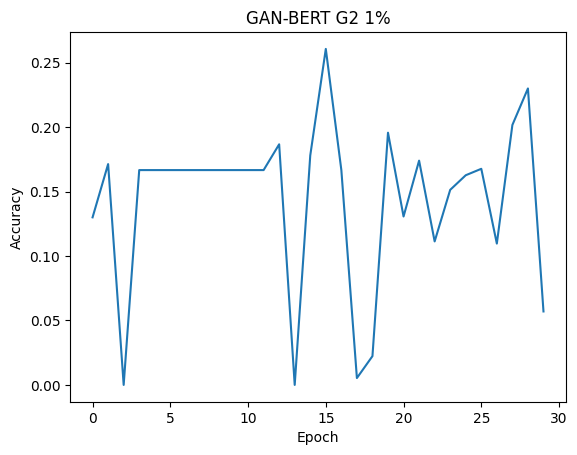

In [23]:
bert = BERT().to(device)
generator_g2 = GeneratorG2().to(device)
discriminator = Discriminator(6).to(device)
accs_g2_1 = train_gan_g2(generator_g2, discriminator, bert, sample_1_loader, epochs=30)
plot(accs_g2_1, 'GAN-BERT G2 1%')

### 5%

Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [00:08<00:00,  5.64it/s]


Epoch 1/6 - Accuracy: 0.16666666666666666


Accuracy: 0.2966666666666667: 100%|██████████| 47/47 [00:08<00:00,  5.50it/s]  


Epoch 2/6 - Accuracy: 0.2966666666666667


Accuracy: 0.3546666666666667: 100%|██████████| 47/47 [00:08<00:00,  5.64it/s] 


Epoch 3/6 - Accuracy: 0.3546666666666667


Accuracy: 0.3456666666666667: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s] 


Epoch 4/6 - Accuracy: 0.3456666666666667


Accuracy: 0.29133333333333333: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Epoch 5/6 - Accuracy: 0.29133333333333333


Accuracy: 0.285: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s]              


Epoch 6/6 - Accuracy: 0.285


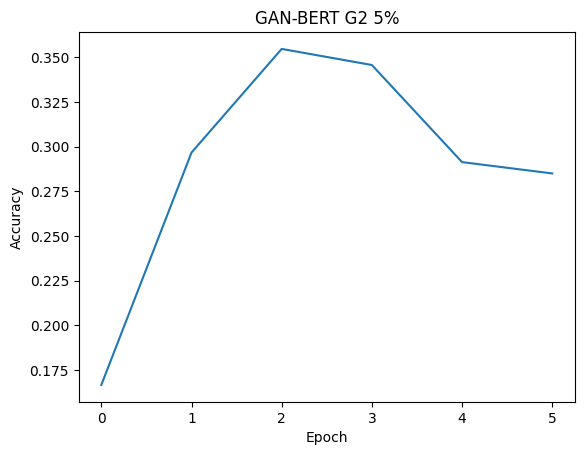

In [24]:
bert = BERT().to(device)
generator_g2 = GeneratorG2().to(device)
discriminator = Discriminator(6).to(device)
accs_g2_2 = train_gan_g2(generator_g2, discriminator, bert, sample_2_loader, epochs=6)
plot(accs_g2_2, 'GAN-BERT G2 5%')

### 10%

Accuracy: 0.30333333333333334: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it] 


Epoch 1/3 - Accuracy: 0.30333333333333334


Accuracy: 0.3883333333333333: 100%|██████████| 47/47 [00:09<00:00,  4.75it/s] 


Epoch 2/3 - Accuracy: 0.3883333333333333


Accuracy: 0.454: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]              

Epoch 3/3 - Accuracy: 0.454


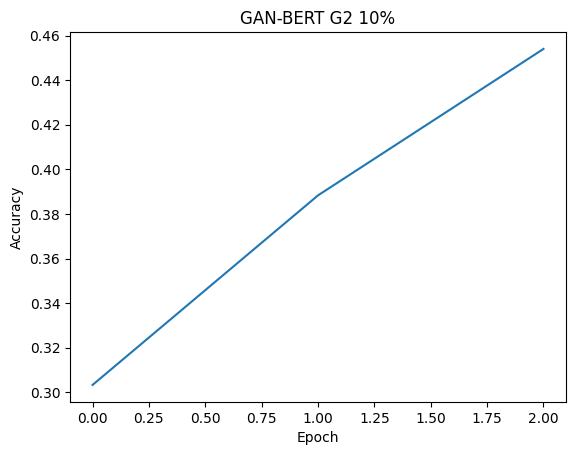

In [25]:
bert = BERT().to(device)
generator_g2 = GeneratorG2().to(device)
discriminator = Discriminator(6).to(device)
accs_g2_3 = train_gan_g2(generator_g2, discriminator, bert, sample_3_loader, epochs=3)
plot(accs_g2_3, 'GAN-BERT G2 10%')

### 50%

Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]


Epoch 1/3 - Accuracy: 0.16666666666666666


Accuracy: 0.0: 100%|██████████| 47/47 [00:16<00:00,  2.87it/s]


Epoch 2/3 - Accuracy: 0.0


Accuracy: 0.16666666666666666: 100%|██████████| 47/47 [01:19<00:00,  1.68s/it]

Epoch 3/3 - Accuracy: 0.16666666666666666


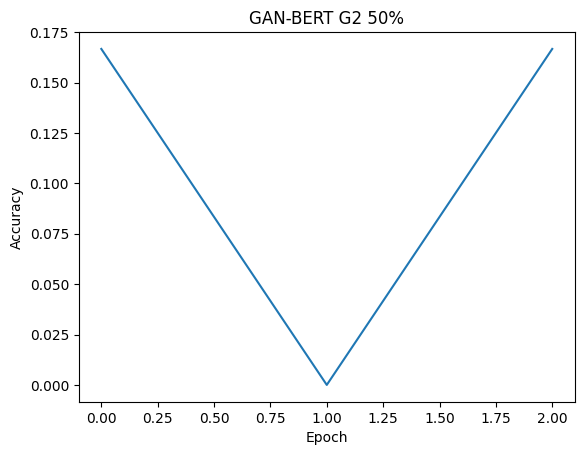

In [26]:
bert = BERT().to(device)
generator_g2 = GeneratorG2().to(device)
discriminator = Discriminator(6).to(device)
accs_g2_4 = train_gan_g2(generator_g2, discriminator, bert, sample_4_loader, epochs=3)
plot(accs_g2_4, 'GAN-BERT G2 50%')

## Generator G3

In [8]:
class GeneratorG3(nn.Module):
    def __init__(self):
        super(GeneratorG3, self).__init__()
        self.fc1 = nn.Linear(100, 2048)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(2048, 1024)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(1024, 768)

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### 1%

Accuracy: 0.17833333333333334: 100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Epoch 1/30 - Accuracy: 0.17833333333333334


Accuracy: 0.205: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s]              


Epoch 2/30 - Accuracy: 0.205


Accuracy: 0.13633333333333333: 100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Epoch 3/30 - Accuracy: 0.13633333333333333


Accuracy: 0.289: 100%|██████████| 47/47 [00:07<00:00,  6.14it/s]              


Epoch 4/30 - Accuracy: 0.289


Accuracy: 0.17633333333333334: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s]


Epoch 5/30 - Accuracy: 0.17633333333333334


Accuracy: 0.175: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s]              


Epoch 6/30 - Accuracy: 0.175


Accuracy: 0.219: 100%|██████████| 47/47 [00:08<00:00,  5.42it/s]              


Epoch 7/30 - Accuracy: 0.219


Accuracy: 0.239: 100%|██████████| 47/47 [00:09<00:00,  5.19it/s]              


Epoch 8/30 - Accuracy: 0.239


Accuracy: 0.23333333333333334: 100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Epoch 9/30 - Accuracy: 0.23333333333333334


Accuracy: 0.2763333333333333: 100%|██████████| 47/47 [00:09<00:00,  4.79it/s] 


Epoch 10/30 - Accuracy: 0.2763333333333333


Accuracy: 0.386: 100%|██████████| 47/47 [00:09<00:00,  4.79it/s]              


Epoch 11/30 - Accuracy: 0.386


Accuracy: 0.373: 100%|██████████| 47/47 [00:10<00:00,  4.69it/s]              


Epoch 12/30 - Accuracy: 0.373


Accuracy: 0.37533333333333335: 100%|██████████| 47/47 [00:10<00:00,  4.55it/s]


Epoch 13/30 - Accuracy: 0.37533333333333335


Accuracy: 0.3426666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.52it/s] 


Epoch 14/30 - Accuracy: 0.3426666666666667


Accuracy: 0.3476666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s] 


Epoch 15/30 - Accuracy: 0.3476666666666667


Accuracy: 0.3473333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.53it/s] 


Epoch 16/30 - Accuracy: 0.3473333333333333


Accuracy: 0.327: 100%|██████████| 47/47 [00:10<00:00,  4.52it/s]              


Epoch 17/30 - Accuracy: 0.327


Accuracy: 0.35533333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.34it/s]


Epoch 18/30 - Accuracy: 0.35533333333333333


Accuracy: 0.3263333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.32it/s] 


Epoch 19/30 - Accuracy: 0.3263333333333333


Accuracy: 0.4736666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.48it/s] 


Epoch 20/30 - Accuracy: 0.4736666666666667


Accuracy: 0.3343333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s] 


Epoch 21/30 - Accuracy: 0.3343333333333333


Accuracy: 0.4196666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.28it/s] 


Epoch 22/30 - Accuracy: 0.4196666666666667


Accuracy: 0.4046666666666667: 100%|██████████| 47/47 [00:10<00:00,  4.29it/s] 


Epoch 23/30 - Accuracy: 0.4046666666666667


Accuracy: 0.3953333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.43it/s] 


Epoch 24/30 - Accuracy: 0.3953333333333333


Accuracy: 0.3473333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s] 


Epoch 25/30 - Accuracy: 0.3473333333333333


Accuracy: 0.41333333333333333: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch 26/30 - Accuracy: 0.41333333333333333


Accuracy: 0.401: 100%|██████████| 47/47 [00:11<00:00,  4.22it/s]              


Epoch 27/30 - Accuracy: 0.401


Accuracy: 0.388: 100%|██████████| 47/47 [00:10<00:00,  4.32it/s]              


Epoch 28/30 - Accuracy: 0.388


Accuracy: 0.42233333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


Epoch 29/30 - Accuracy: 0.42233333333333334


Accuracy: 0.417: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]              


Epoch 30/30 - Accuracy: 0.417


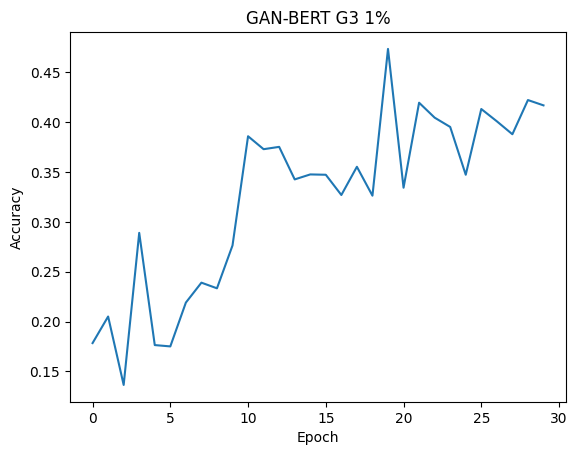

In [9]:
bert = BERT().to(device)
generator_g3 = GeneratorG3().to(device)
discriminator = Discriminator(6).to(device)
accs_g3_1 = train_gan_g1(generator_g3, discriminator, bert, sample_1_loader, epochs=30)
plot(accs_g3_1, 'GAN-BERT G3 1%')

### 5%

Accuracy: 0.142: 100%|██████████| 47/47 [00:10<00:00,  4.30it/s]              


Epoch 1/6 - Accuracy: 0.142


Accuracy: 0.20633333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s]


Epoch 2/6 - Accuracy: 0.20633333333333334


Accuracy: 0.43666666666666665: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


Epoch 3/6 - Accuracy: 0.43666666666666665


Accuracy: 0.43966666666666665: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


Epoch 4/6 - Accuracy: 0.43966666666666665


Accuracy: 0.475: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]              


Epoch 5/6 - Accuracy: 0.475


Accuracy: 0.48133333333333334: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


Epoch 6/6 - Accuracy: 0.48133333333333334


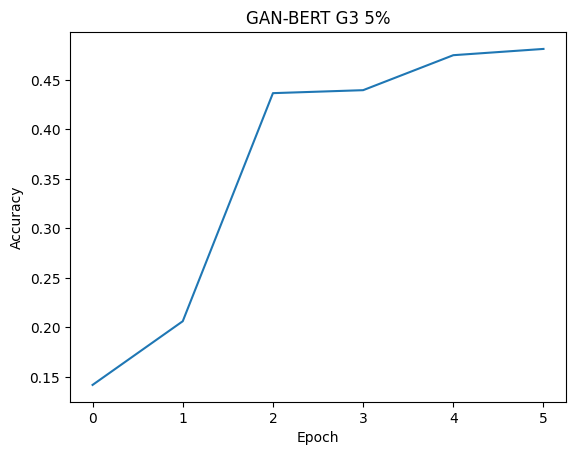

In [10]:
bert = BERT().to(device)
generator_g3 = GeneratorG3().to(device)
discriminator = Discriminator(6).to(device)
accs_g3_2 = train_gan_g1(generator_g3, discriminator, bert, sample_2_loader, epochs=6)
plot(accs_g3_2, 'GAN-BERT G3 5%')

### 10%

Accuracy: 0.2856666666666667: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s] 


Epoch 1/3 - Accuracy: 0.2856666666666667


Accuracy: 0.467: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s]              


Epoch 2/3 - Accuracy: 0.467


Accuracy: 0.4706666666666667: 100%|██████████| 47/47 [00:11<00:00,  4.11it/s] 

Epoch 3/3 - Accuracy: 0.4706666666666667


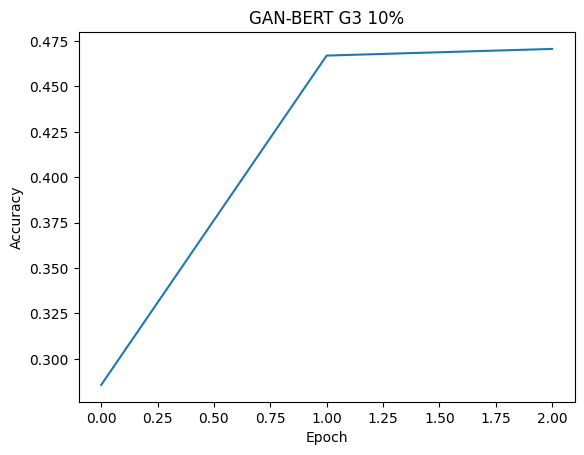

In [11]:
bert = BERT().to(device)
generator_g3 = GeneratorG3().to(device)
discriminator = Discriminator(6).to(device)
accs_g3_3 = train_gan_g1(generator_g3, discriminator, bert, sample_3_loader, epochs=3)
plot(accs_g3_3, 'GAN-BERT G3 10%')

### 50%

Accuracy: 0.451: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]              


Epoch 1/3 - Accuracy: 0.451


Accuracy: 0.48: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s]               


Epoch 2/3 - Accuracy: 0.48


Accuracy: 0.503: 100%|██████████| 47/47 [00:34<00:00,  1.36it/s]              


Epoch 3/3 - Accuracy: 0.503


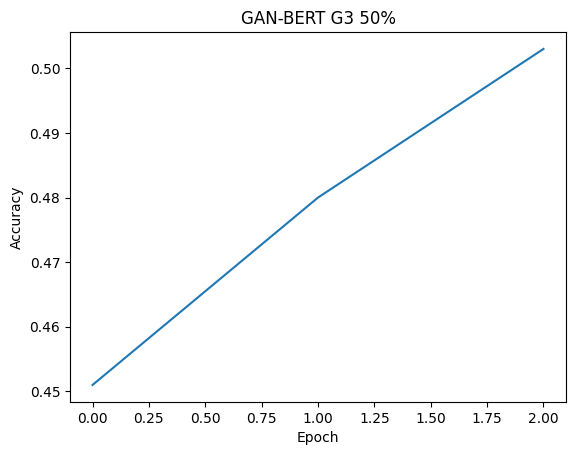

In [12]:
bert = BERT().to(device)
generator_g3 = GeneratorG3().to(device)
discriminator = Discriminator(6).to(device)
accs_g3_4 = train_gan_g1(generator_g3, discriminator, bert, sample_4_loader, epochs=3)
plot(accs_g3_4, 'GAN-BERT G3 50%')

# BERT Deep Classifier

In [22]:
class BERTDeepClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTDeepClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        self.classifier = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.pooler_output)

Accuracy: 0.45966666666666667: 100%|██████████| 47/47 [00:55<00:00,  1.19s/it]


Epoch 1/3 - Accuracy: 0.45966666666666667


Accuracy: 0.477: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]              


Epoch 2/3 - Accuracy: 0.477


Accuracy: 0.486: 100%|██████████| 47/47 [00:54<00:00,  1.15s/it]              


Epoch 3/3 - Accuracy: 0.486


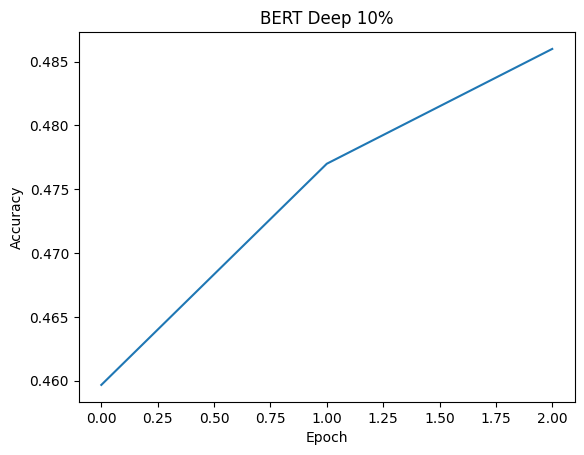

In [23]:
model = BERTDeepClassifier(6).to(device)
accs_d_3 = train(model, sample_3_loader, epochs=3)
plot(accs_d_3, 'BERT Deep 10%')